# Exercício de fixação de conceitos 1

## Objetivo

O objetivo desse Jupyter Notebook é exercitar conceitos de Aprendizado de Máquina ligados essencialmente à Regressão Linear, dentre eles:

- Cross Validation
- K-fold
- Critério de Root Mean Square Error (RMSE)
- Regressor Linear ótimo em forma fechada
- Ridge regression
- Mapeamentos não-lineares em regressão linear 

## Problema abordado

O problema a ser trabalhado consite em predizer o número de manchas solares em uma série temporal. O datasheet fornecido contém dados mensais de manchas solares desde o ano de 1749 até 2019.

## Importação de bibliotecas


In [1]:
import pandas as pd
import math
import numpy as np
from numpy import genfromtxt
from numpy import linalg
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


Leitura dos dados a partir da planilha em excel:

In [2]:
manchas = genfromtxt('monthly-sunspots.csv', delimiter=',')

Exclusão das colunas de índice e data:

In [3]:
manchas = np.delete(manchas,np.s_[0:2],axis=1)
manchas = np.delete(manchas,0,axis=0)

Visualisação dos dados de manchas solares:

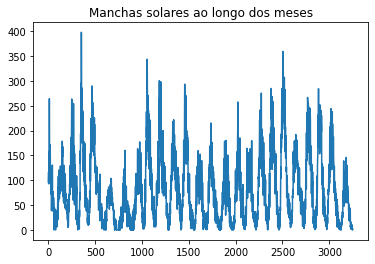

In [4]:
plt.plot(manchas)
plt.title("Manchas solares ao longo dos meses")
plt.show()

## Parte 1 

Montagem da matriz de entrada e do vetor de saídas esperadas:



In [5]:
K = 24
X = toeplitz(manchas[::-1]) # matriz de entrada
y = manchas[K:] # vetor de saída
N = len(y)
print(X)
print(y)

[[  1.6   0.5   0.4 ... 116.7 104.3  96.7]
 [  0.5   1.6   0.5 ...  92.8 116.7 104.3]
 [  0.4   0.5   1.6 ... 141.7  92.8 116.7]
 ...
 [116.7  92.8 141.7 ...   1.6   0.5   0.4]
 [104.3 116.7  92.8 ...   0.5   1.6   0.5]
 [ 96.7 104.3 116.7 ...   0.4   0.5   1.6]]
[[116.7]
 [ 72.5]
 [ 75.5]
 ...
 [  0.4]
 [  0.5]
 [  1.6]]


In [6]:
XL = X[:,:K]
XL = XL[::-1]
XL = XL[:-K]
XL

array([[ 96.7, 104.3, 116.7, ..., 109.5, 105.5, 125.7],
       [104.3, 116.7,  92.8, ..., 105.5, 125.7, 116.7],
       [116.7,  92.8, 141.7, ..., 125.7, 116.7,  72.5],
       ...,
       [ 13.2,   5.7,   8.2, ...,   0.9,   0.5,   1.1],
       [  5.7,   8.2,   6.8, ...,   0.5,   1.1,   0.4],
       [  8.2,   6.8,  10.7, ...,   1.1,   0.4,   0.5]])

Obteve-se uma matriz de entrada XL com 24 colunas e número de linhas igual ao número de dados menos 24.

Divisão dos dados em grupo de treinamento e grupo de teste (5 anos ou 120 meses):

In [7]:
Xtest = XL[-120:,:]
ytest = y[-120:,:]
Xtrain = XL[:-120,:]
ytrain = y[:-120,:]

Definisão da função rmse:

In [8]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Exercício computacional 01

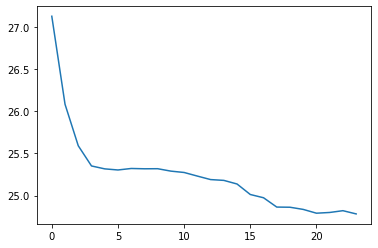

In [9]:
n_splits_kfold = 4
kf = KFold(n_splits = n_splits_kfold)

rmse_vec = np.zeros(K)
for j in range(K,0,-1):
    Xtrain_subset = Xtrain[:,j-1:]
    
    rmse_acc = 0 

    for train_index, test_index in kf.split(Xtrain_subset):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kfold, X_test_kfold = Xtrain_subset[train_index], Xtrain_subset[test_index]
        y_train_kfold, y_test_kfold = ytrain[train_index], ytrain[test_index]
        
        reg = LinearRegression(fit_intercept=True).fit(X_train_kfold, y_train_kfold)
        ypred_kfold = reg.predict(X_test_kfold)
        rmse_acc += rmse(y_test_kfold, ypred_kfold)
    
    rmse_vec[K-j] = rmse_acc/n_splits_kfold
    #print(rmse_acc, rmse_vec[K-k])

plt.plot(rmse_vec)

best_k = rmse_vec.argmin() + 1



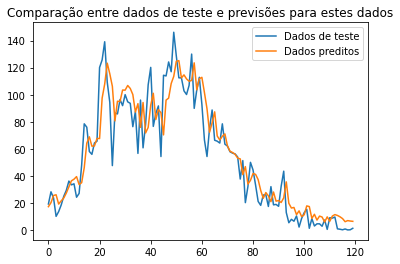

In [10]:
Xtrain_final = Xtrain[:,-best_k:]
Xtest_final = Xtest[:,-best_k:]
reg_final = LinearRegression(fit_intercept=True).fit(Xtrain_final, ytrain)
ypred_test = reg_final.predict(Xtest_final)
rmse_final = rmse(ytest, ypred_test)
rmse_final
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test,label = 'Dados preditos')
plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()


In [11]:
rmse_final

16.394732558477774

# Exercício computacional 02


In [12]:
K2 = 8
Xtrain2 = Xtrain[:,-K2:]
Xtest2 = Xtest[:,-K2:]
print(Xtrain2.shape)
print(Xtest2.shape)

(3108, 8)
(120, 8)


## Normalização da série

Por se tratar da predição de uma série temporal, pode-se normalizar tudo com base no Xtreino, já que tanto as variáveis dependentes quanto as independentes estão na mesma ordem de grandeza.

In [13]:
mean_norm = Xtrain2.mean()
std_norm = Xtrain2.std()
nstd = 4
Xtrain2_norm = (Xtrain2 - mean_norm)/(nstd*std_norm)
Xtest2_norm = (Xtest2 - mean_norm)/(nstd*std_norm)
ytrain2_norm = (ytrain - mean_norm)/(nstd*std_norm)
ytest2_norm = (ytest - mean_norm)/(nstd*std_norm)

(array([1056.,  693.,  527.,  355.,  250.,  139.,   64.,   19.,    3.,
           2.]),
 array([-0.30276605, -0.1573585 , -0.01195096,  0.13345659,  0.27886413,
         0.42427168,  0.56967922,  0.71508677,  0.86049431,  1.00590186,
         1.1513094 ]),
 <BarContainer object of 10 artists>)

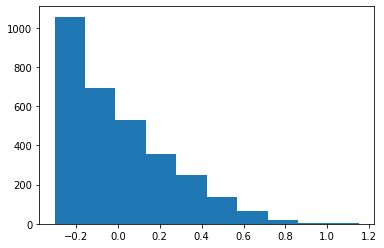

In [14]:
plt.hist(Xtrain2_norm[:,0])

## Estruturação da matriz de combinação W com T vetores gerados aleatoriamente

In [15]:
n_splits_kfold2 = 4
kf2 = KFold(n_splits = n_splits_kfold2)
lambvec = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
Tvec = np.linspace(1,100,100)
result = np.zeros([len(Tvec),len(lambvec)])

for t in range(len(Tvec)):

    for lambridge in range(len(lambvec)):
        w = np.random.rand(K2,t+1)
        wXtrainL = np.tanh((w.T@Xtrain2_norm.T).T)

        rmseT = 0
        
        for train_index, test_index in kf2.split(Xtrain2_norm):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kfold2, X_test_kfold2 = wXtrainL[train_index], wXtrainL[test_index]
            y_train_kfold2, y_test_kfold2 = ytrain2_norm[train_index], ytrain2_norm[test_index]
            
            reg2 = Ridge(alpha = lambvec[lambridge],fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
            y_pred_kfold2 = reg2.predict(X_test_kfold2)

            y_test_kfold2 = y_test_kfold2*nstd*std_norm + mean_norm
            y_pred_kfold2 = y_pred_kfold2*nstd*std_norm + mean_norm

            rmseT += rmse(y_test_kfold2, y_pred_kfold2)
        result[t,lambridge] = rmseT/n_splits_kfold2
        print(lambvec[lambridge],t,result[t,lambridge]) 
    

0.001 0 33.45736281370999
0.01 0 34.16111642325777
0.1 0 33.59675278689464
1.0 0 33.33481818801885
10.0 0 31.4085404808163
100.0 0 33.686386494050794
1000.0 0 46.07127077016566
0.001 1 29.702839089849284
0.01 1 31.57712647792649
0.1 1 31.738431304812785
1.0 1 29.782524901221844
10.0 1 33.16359073807836
100.0 1 30.222556680887813
1000.0 1 39.09196370959005
0.001 2 32.968237112189215
0.01 2 31.8628240678374
0.1 2 33.68985900410918
1.0 2 32.58040150059939
10.0 2 30.793749849891114
100.0 2 32.367221433257036
1000.0 2 35.80670394893892
0.001 3 30.810601265102285
0.01 3 29.269066338174916
0.1 3 27.74279286459815
1.0 3 31.744746309214072
10.0 3 29.75187206524033
100.0 3 32.020186111152974
1000.0 3 35.30264730764757
0.001 4 26.94126683310934
0.01 4 28.95239224719808
0.1 4 27.867647739475267
1.0 4 27.932751620921486
10.0 4 32.97048704776852
100.0 4 31.153218788887727
1000.0 4 34.13519379446438
0.001 5 27.997929668151667
0.01 5 28.82827677725674
0.1 5 27.097805175171906
1.0 5 26.030419486094274


In [16]:
bestlamb4T=np.amin(result, axis=1)
print(bestlamb4T)
indlamb = np.where(result == np.amin(result,axis=1))
print('Returned tuple of arrays :', indlamb)
print('List of Indices of minimum element :', indlamb[0])

[31.40854048 29.70283909 30.79374985 27.74279286 26.94126683 26.03041949
 26.80343446 26.75784931 27.13040893 26.186427   26.0906707  26.68262228
 25.93816596 25.77889792 25.5587328  25.68852134 26.01821178 25.62927488
 25.70479297 25.76397254 25.72949367 25.64214441 25.54997896 25.74791661
 25.53808481 25.6852024  25.54202584 25.63835092 25.43118671 25.75613592
 25.68710282 25.48853382 25.53625857 25.68994043 25.64128502 25.56568285
 25.66757664 25.73079028 25.73333356 25.6594551  25.71627396 25.68321539
 25.51653023 25.61965295 25.6395774  25.65276966 25.69432838 25.67421137
 25.62268106 25.7190537  25.59219891 25.63743264 25.5105749  25.55979547
 25.64861575 25.58281986 25.687382   25.57072208 25.55941598 25.53180144
 25.64649824 25.63352034 25.71252573 25.61576063 25.54577002 25.63531282
 25.57010005 25.53340243 25.46882534 25.50835999 25.54983203 25.48250133
 25.66572695 25.57766831 25.51980967 25.59499341 25.50407953 25.6524744
 25.53108667 25.56118142 25.54225329 25.57026138 25.

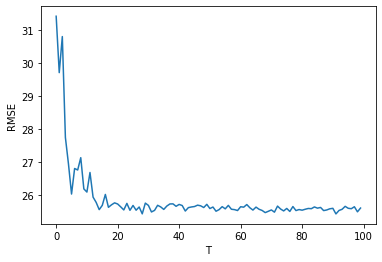

In [17]:
# gráfico RMSE x T
rmse_min = []
rmse_mean = []
bestlamb4T = []
for i in range(len(Tvec)):
    rmse_min.append(min(result[i]))
    rmse_mean.append(np.mean(result[i]))
    bestlamb4T.append(min(result[i]))

plt.plot(range(len(rmse_min)),rmse_min)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

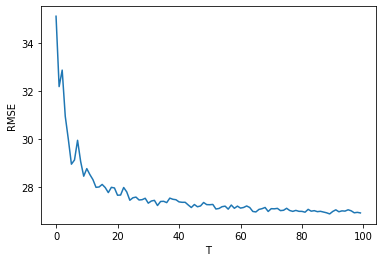

In [18]:
plt.plot(range(len(rmse_mean)),rmse_mean)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

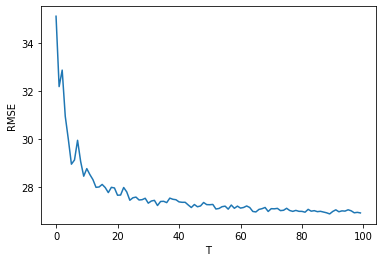

In [19]:
plt.plot(range(len(rmse_mean)),rmse_mean)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

In [20]:
# cálculo index_min
amin = np.where(result == np.amin(result))
index_min = list(zip(amin[0],amin[1]))
print(index_min)

[(91, 2)]


[4, 0, 4, 2, 0, 3, 1, 0, 3, 2, 0, 3, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2]
[10.0, 0.001, 10.0, 0.1, 0.001, 1.0, 0.01, 0.001, 1.0, 0.1, 0.001, 1.0, 0.001, 0.001, 0.01, 0.001, 0.001, 0.001, 0.01, 0.01, 0.001, 0.001, 0.01, 0.01, 0.1, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0.001, 0.1, 0.01, 0.01, 0.1, 0.01, 0.01, 0.01, 0.001, 0.01, 0.01, 0.1, 0.01, 0.1, 0.1, 0.01, 0.001, 0.1, 0.01, 0.1, 0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.01, 0.01, 0.1, 0.01, 0.1, 0.1, 0.1, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]


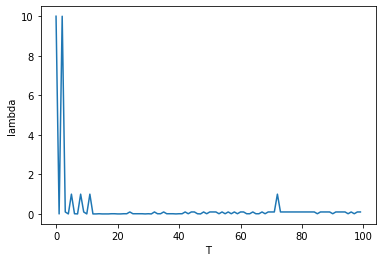

In [21]:
# b.) melhor valor do parâmetro de regularização para cada valor de T
index_array = []
index_minimo = []
lamb = []
for i in range(len(result)):
    index_array.append(np.where(result[i] == np.amin(result[i])))
    index_minimo.append(index_array[i][0][0])
    lamb.append(lambvec[index_minimo[i]])
    
print(index_minimo)
print(lamb)
plt.plot(range(len(lamb)),lamb)
plt.xlabel("T")
plt.ylabel("lambda")
plt.show()

In [22]:
# valor de T e lambda
T = (index_min[0][0]) + 1
lamb = lambvec[index_min[0][1]]

print('Mínimo valor de RMSE:',min(rmse_min))
print('Valor de T estimado:',T)
print('Valor de lambda estimado:',lamb)

Mínimo valor de RMSE: 25.429330669069284
Valor de T estimado: 92
Valor de lambda estimado: 0.1


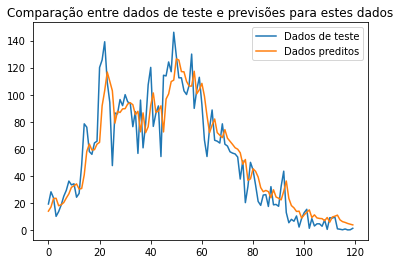

In [23]:
reg_final2 = Ridge(alpha = lambridge,fit_intercept=True).fit(Xtrain2_norm, ytrain2_norm)
ypred_test2_norm = reg_final2.predict(Xtest2_norm)
ypred_test2 = ypred_test2_norm*nstd*std_norm + mean_norm
rmse_final2 = rmse(ytest, ypred_test2)
rmse_final2
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test2,label = 'Dados preditos')
plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()

In [24]:
rmse_final2

16.228482634522912